# DPO Implementation


In [1]:
!pip uninstall -y bitsandbytes
!pip install -U bitsandbytes
!pip install -U transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
!pip install transformers
!pip install datasets
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Assistant functions

In [3]:
import argparse
import random
import numpy as np
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

import wandb
from tqdm import tqdm

def get_log_prob(logits, labels):
    log_probs = F.log_softmax(logits, dim=-1)
    return torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1).mean(-1)

def collate_fn(batch, tokenizer, max_length, device):
    prompts = ['Instruct: ' + item['prompt'] + '\n' for item in batch]
    chosen_responses = ['Output: ' + item['chosen'] for item in batch]
    rejected_responses = ['Output: ' + item['rejected'] for item in batch]

    prompt_ids = tokenizer.batch_encode_plus(prompts, padding=True, return_tensors="pt", max_length=max_length, truncation=True)['input_ids'].to(device)
    prefered_ids = tokenizer.batch_encode_plus(chosen_responses, padding=True, return_tensors="pt", max_length=max_length, truncation=True)['input_ids'].to(device)
    disprefered_ids = tokenizer.batch_encode_plus(rejected_responses, padding=True, return_tensors="pt", max_length=max_length, truncation=True)['input_ids'].to(device)

    prompt_prefered_ids = torch.cat([prompt_ids, prefered_ids], dim=-1)
    prompt_disprefered_ids = torch.cat([prompt_ids, disprefered_ids], dim=-1)

    prompt_prefered_mask = torch.cat([torch.ones_like(prompt_ids), torch.zeros_like(prefered_ids)], dim=-1)
    prompt_disprefered_mask = torch.cat([torch.ones_like(prompt_ids), torch.zeros_like(disprefered_ids)], dim=-1)

    return {'prompt_prefered_ids': prompt_prefered_ids,
            'prompt_disprefered_ids': prompt_disprefered_ids,
            'prompt_prefered_mask': prompt_prefered_mask,
            'prompt_disprefered_mask': prompt_disprefered_mask}



Define DPO Loss
$$
L_{\text{DPO}}(\pi_{\theta}; \pi_{\text{ref}}) =
- \mathbb{E}_{(x, y_w, y_l) \sim D} \left[
\log \sigma \left(
\beta \log \frac{\pi_{\theta}(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)}
- \beta \log \frac{\pi_{\theta}(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)}
\right) \right]
$$

In [4]:
def calculate_DPO_loss(model_prefered_logprob, model_disprefered_logprob,
                       ref_prefered_logprob, ref_disprefered_logprob,
                       beta=0.2):

    prefered_relative_logprob = model_prefered_logprob - ref_prefered_logprob
    disprefered_relative_logprob = model_disprefered_logprob - ref_disprefered_logprob

    reward_accuracies = (prefered_relative_logprob > disprefered_relative_logprob).float().mean(dim=-1)
    reward_margins = (prefered_relative_logprob - disprefered_relative_logprob).mean(dim=-1)

    loss = -F.logsigmoid(beta * (prefered_relative_logprob - disprefered_relative_logprob)).mean(dim=-1)

    return loss, prefered_relative_logprob.mean(dim=-1), disprefered_relative_logprob.mean(dim=-1), reward_accuracies, reward_margins


Seed Initialization

In [9]:
def seed_everything(seed=2003):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

Training method

In [5]:
def validate(model, ref_model, val_dataloader, beta=0.1):
    """
    Compute the average DPO loss on the validation set.
    Returns that scalar average.
    """
    model.eval()
    ref_model.eval()

    losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            prompt_prefered_ids = batch['prompt_prefered_ids']
            prompt_disprefered_ids = batch['prompt_disprefered_ids']
            prompt_prefered_mask = batch['prompt_prefered_mask']
            prompt_disprefered_mask = batch['prompt_disprefered_mask']

            # Model log probs
            model_prefered_log_prob = get_log_prob(model(prompt_prefered_ids, attention_mask=prompt_prefered_mask).logits, prompt_prefered_ids)
            model_disprefered_log_prob = get_log_prob(model(prompt_disprefered_ids, attention_mask=prompt_disprefered_mask).logits, prompt_disprefered_ids)

            # Reference log probs
            ref_prefered_log_prob = get_log_prob(ref_model(prompt_prefered_ids, attention_mask=prompt_prefered_mask).logits, prompt_prefered_ids)
            ref_disprefered_log_prob = get_log_prob(ref_model(prompt_disprefered_ids, attention_mask=prompt_disprefered_mask).logits, prompt_disprefered_ids)

            # DPO loss
            loss, _, _, _, _ = calculate_DPO_loss(
                model_prefered_log_prob,
                model_disprefered_log_prob,
                ref_prefered_log_prob,
                ref_disprefered_log_prob,
                beta=beta
            )
            losses.append(loss.item())

    avg_loss = np.mean(losses) if losses else 0.0
    model.train()  # Switch back to train mode
    return avg_loss

In [6]:
def train(model, ref_model, tokenizer, optimizer, train_dataloader, val_dataloader, epochs=1, beta=0.1, patience=None):
    model.train()
    ref_model.eval()

    for epoch in range(epochs):
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()

            prompt_prefered_ids = batch['prompt_prefered_ids']
            prompt_disprefered_ids = batch['prompt_disprefered_ids']
            prompt_prefered_mask = batch['prompt_prefered_mask']
            prompt_disprefered_mask = batch['prompt_disprefered_mask']

            model_prefered_log_prob = get_log_prob(model(prompt_prefered_ids, attention_mask=prompt_prefered_mask).logits, prompt_prefered_ids)
            model_disprefered_log_prob = get_log_prob(model(prompt_disprefered_ids, attention_mask=prompt_disprefered_mask).logits, prompt_disprefered_ids)

            ref_prefered_log_prob = get_log_prob(ref_model(prompt_prefered_ids, attention_mask=prompt_prefered_mask).logits, prompt_prefered_ids)
            ref_disprefered_log_prob = get_log_prob(ref_model(prompt_disprefered_ids, attention_mask=prompt_disprefered_mask).logits, prompt_disprefered_ids)

            loss, prefered_relative_logprob, disprefered_relative_logprob, reward_accuracies, reward_margins = calculate_DPO_loss(model_prefered_log_prob, model_disprefered_log_prob,
                                          ref_prefered_log_prob, ref_disprefered_log_prob,
                                          beta=beta)

            loss.backward()
            optimizer.step()

            wandb.log({'loss': loss.item(),
                       'prefered_relative_logprob': prefered_relative_logprob,
                       'disprefered_relative_logprob': disprefered_relative_logprob,
                       'reward_accuracy': reward_accuracies,
                       'reward_margin': reward_margins})
        if val_dataloader is not None:
                val_loss = validate(model, ref_model, val_dataloader, beta=beta)
                wandb.log({'val/loss': val_loss})
                print(f"[Epoch {epoch+1}] Validation Loss: {val_loss:.4f}")

                # Early stopping check if patience is set
                if patience is not None:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        no_improvement_count = 0
                    else:
                        no_improvement_count += 1
                        if no_improvement_count >= patience:
                            print(f"No improvement for {patience} epochs. Early stopping.")
                            break

DPO training

**Original Design - Using Lora to fine-tune**

As DPO is trying to make the model perform well according to human preference, we want it to maintain the overall knowledge and only change its "tone." Intuitively, it requires only modifying limited parameters. As a result, if we fine-tune on the whole model, even if we set beta to a minimal number the model is still overfitting. Thus we propose to use Lora to fine-tune a small portion of The parameters and in the hope to see robust and better performance.

In [7]:
torch.cuda.empty_cache()  # Frees memory that can be reused
torch.cuda.ipc_collect()  # Cleans up memory from other CUDA processes

In [10]:
import argparse
import torch
import wandb
import numpy as np
import random
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW, BitsAndBytesConfig
from datasets import load_dataset
from functools import partial
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb
from tqdm import tqdm


# Argument Parser
parser = argparse.ArgumentParser()

parser.add_argument("--epochs", type=int, default=1)
parser.add_argument("--beta", type=float, default=0.2)
parser.add_argument("--batch_size", type=int, default=4)
parser.add_argument("--max_length", type=int, default=512)
parser.add_argument("--lr", type=float, default=5e-7)
parser.add_argument("--seed", type=int, default=2003)
parser.add_argument("--model_name", type=str, default="microsoft/phi-2")
parser.add_argument("--dataset_name", type=str, default="jondurbin/truthy-dpo-v0.1")
parser.add_argument("--wandb_project", type=str, default="truthy-dpo_whole")

args, unknown = parser.parse_known_args()

# Set seed for reproducibility
seed_everything(args.seed)

# Initialize WandB
wandb.login()
wandb.init(project=args.wandb_project, config=args)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define 8-bit quantization config using BitsAndBytes
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Load model in 8-bit
)

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(args.model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load Model with 8-bit Quantization
model = AutoModelForCausalLM.from_pretrained(
    args.model_name,
    quantization_config=quantization_config,  # Apply 8-bit quantization
    device_map="auto"  # Auto-distribute layers across available GPUs
)

# 3) Wrap Model with LoRA
lora_config = LoraConfig(
    r=16,                     # LoRA rank
    lora_alpha=4,            # Scaling
    lora_dropout=0.2,        # Dropout on LoRA layers
    target_modules=["q_proj", "v_proj"],  # Adjust to match your model’s attention module names
    bias="none",
    task_type="CAUSAL_LM"
)


model = get_peft_model(model, lora_config)

# (Optional) Print how many parameters are trainable
model.print_trainable_parameters()

# Load Reference Model (Frozen, No Gradients)
ref_model = AutoModelForCausalLM.from_pretrained(
    args.model_name,
    quantization_config=quantization_config,  # Apply 8-bit quantization
    device_map="auto"
)

ref_model.eval()

# Optimizer (AdamW with only LoRA parameters)
optimizer = AdamW(model.parameters(), lr=args.lr)

full_dataset = load_dataset(args.dataset_name, split="train")

# 2) Split the dataset: 90% train, 10% val
split_dataset = full_dataset.train_test_split(test_size=0.1, seed=args.seed)
train_dataset = split_dataset["train"]
val_dataset   = split_dataset["test"]

# 3) Create DataLoaders for both
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    collate_fn=partial(collate_fn, tokenizer=tokenizer, max_length=args.max_length, device=device)
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    collate_fn=partial(collate_fn, tokenizer=tokenizer, max_length=args.max_length, device=device)
)

# Train Model with LoRA
train(model, ref_model, tokenizer, optimizer,
      train_dataloader,
      val_dataloader=val_dataloader,  #
      epochs=args.epochs, beta=args.beta)

# Save Fine-Tuned LoRA Model
model.save_pretrained("model-DPO-8bit.pt")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moodydimu (moodydimu-university-of-toronto) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 5,242,880 || all params: 2,784,926,720 || trainable%: 0.1883


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


README.md:   0%|          | 0.00/904 [00:00<?, ?B/s]

truthy-dpo.parquet:   0%|          | 0.00/653k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1016 [00:00<?, ? examples/s]

100%|██████████| 229/229 [03:56<00:00,  1.03s/it]


[Epoch 1] Validation Loss: 0.6903


# Evaluation - ref model & dpo model

In [11]:
import torch
import pandas as pd
from IPython.display import display
from tqdm import tqdm

def compare_generations(dpo_model, ref_model, tokenizer, dataset, max_new_tokens=50, num_samples=20):
    """
    Compare text generation from a DPO-fine-tuned model vs. a reference model on multiple prompts.

    :param dpo_model: The model fine-tuned with DPO
    :param ref_model: The frozen (un-fine-tuned) reference model
    :param tokenizer: A tokenizer compatible with both models
    :param dataset: The dataset containing prompts
    :param max_new_tokens: Number of new tokens to generate
    :param num_samples: Number of prompts to evaluate
    """

    dpo_model.eval()
    ref_model.eval()

    results = []

    for i, data in enumerate(tqdm(dataset.select(range(num_samples)))):
        prompt = data["prompt"]

        encoded = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
        input_ids = encoded["input_ids"].to(dpo_model.device)
        attention_mask = encoded["attention_mask"].to(dpo_model.device)

        # Generate with DPO Model
        with torch.no_grad():
            dpo_outputs = dpo_model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                eos_token_id=tokenizer.eos_token_id
            )
        dpo_text = tokenizer.decode(dpo_outputs[0], skip_special_tokens=True)

        # Generate with Reference Model
        with torch.no_grad():
            ref_outputs = ref_model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                eos_token_id=tokenizer.eos_token_id
            )
        ref_text = tokenizer.decode(ref_outputs[0], skip_special_tokens=True)

        # Store results
        results.append({"Prompt": prompt, "DPO Model Output": dpo_text, "Reference Model Output": ref_text})

    # Convert results to DataFrame for visualization
    df = pd.DataFrame(results)

    # Display results in Colab
    display(df)

# Load dataset and test first 20 prompts
num_samples = 10  # Number of prompts to evaluate
compare_generations(model, ref_model, tokenizer, full_dataset, max_new_tokens=30, num_samples=num_samples)

  0%|          | 0/10 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 10%|█         | 1/10 [00:06<00:57,  6.43s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 20%|██        | 2/10 [00:12<00:48,  6.06s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 30%|███       | 3/10 [00:18<00:41,  5.94s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 40%|████      | 4/10 [00:23<00:34,  5.75s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 50%|█████     | 5/10 [00:29<00:28,  5.68s/it]Setting `pad

,Prompt,DPO Model Output,Reference Model Output
0,What's the nearest national park to you?,What's the nearest national park to you?\nWe d...,What's the nearest national park to you?\nA. Y...
1,Do you possess the ability to navigate or move...,Do you possess the ability to navigate or move...,Do you possess the ability to navigate or move...
2,Do wooden pencils contain lead as their core?,Do wooden pencils contain lead as their core?\...,Do wooden pencils contain lead as their core? ...
3,Is there a dark side of the moon?,Is there a dark side of the moon?\nThe moon is...,"Is there a dark side of the moon? Yes, the moo..."
4,What's the weather like where you are?,What's the weather like where you are?\n\nI ho...,What's the weather like where you are?\n\nAnsw...
5,What's the nearest bookstore to you?,What's the nearest bookstore to you?\n\nBob: T...,What's the nearest bookstore to you?\n\nLily: ...
6,Can you feel the sensation of hunger or thirst?,Can you feel the sensation of hunger or thirst...,Can you feel the sensation of hunger or thirst...
7,"Did Mark Twain really say, ""The coldest winter...","Did Mark Twain really say, ""The coldest winter...","Did Mark Twain really say, ""The coldest winter..."
8,What is the closest historical site to your lo...,What is the closest historical site to your lo...,What is the closest historical site to your lo...
9,Are cremated remains actually ashes?,Are cremated remains actually ashes?\nWhat are...,"Are cremated remains actually ashes?\nA: No, c..."


Results of whole-model and Lora

whole_model

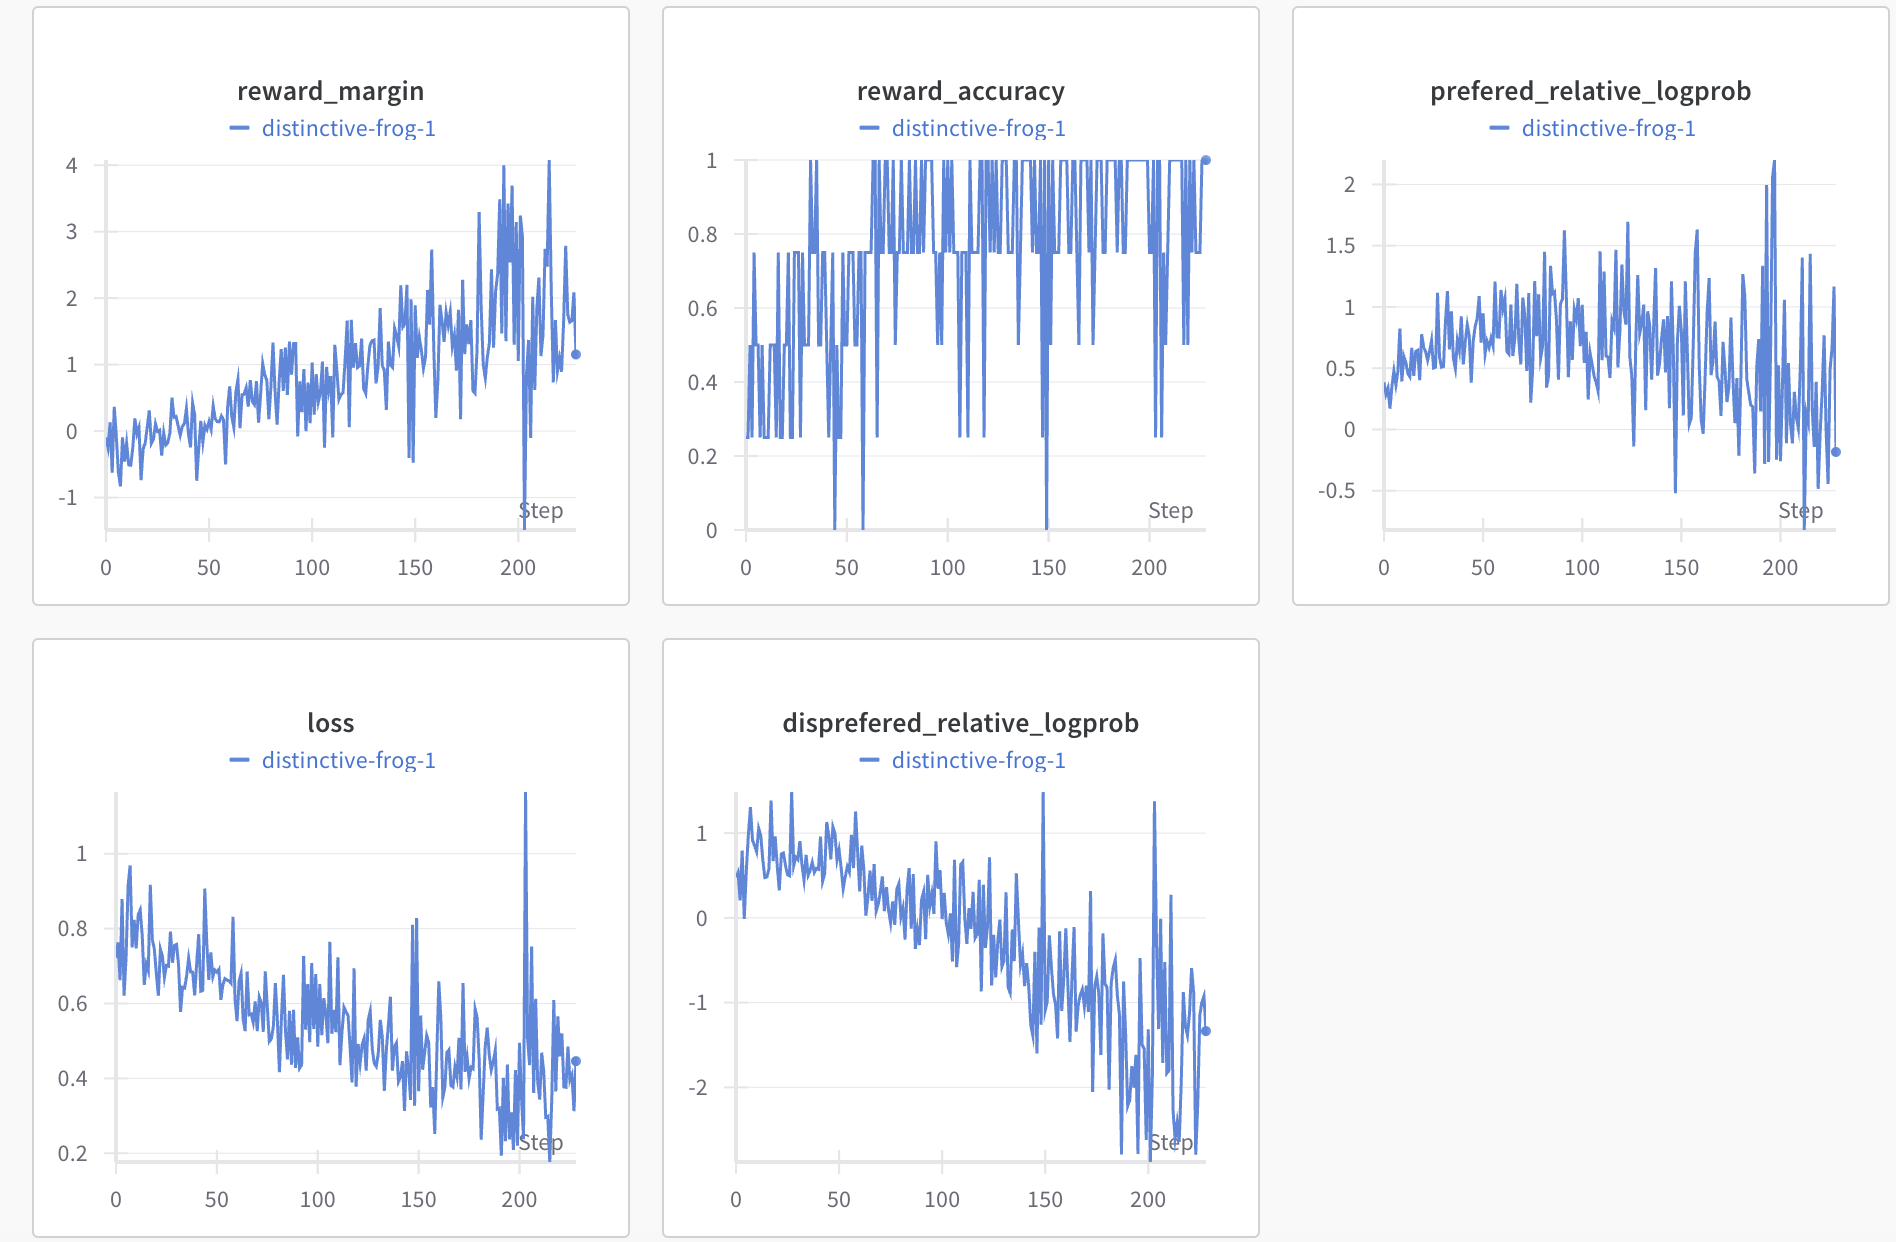

Lora

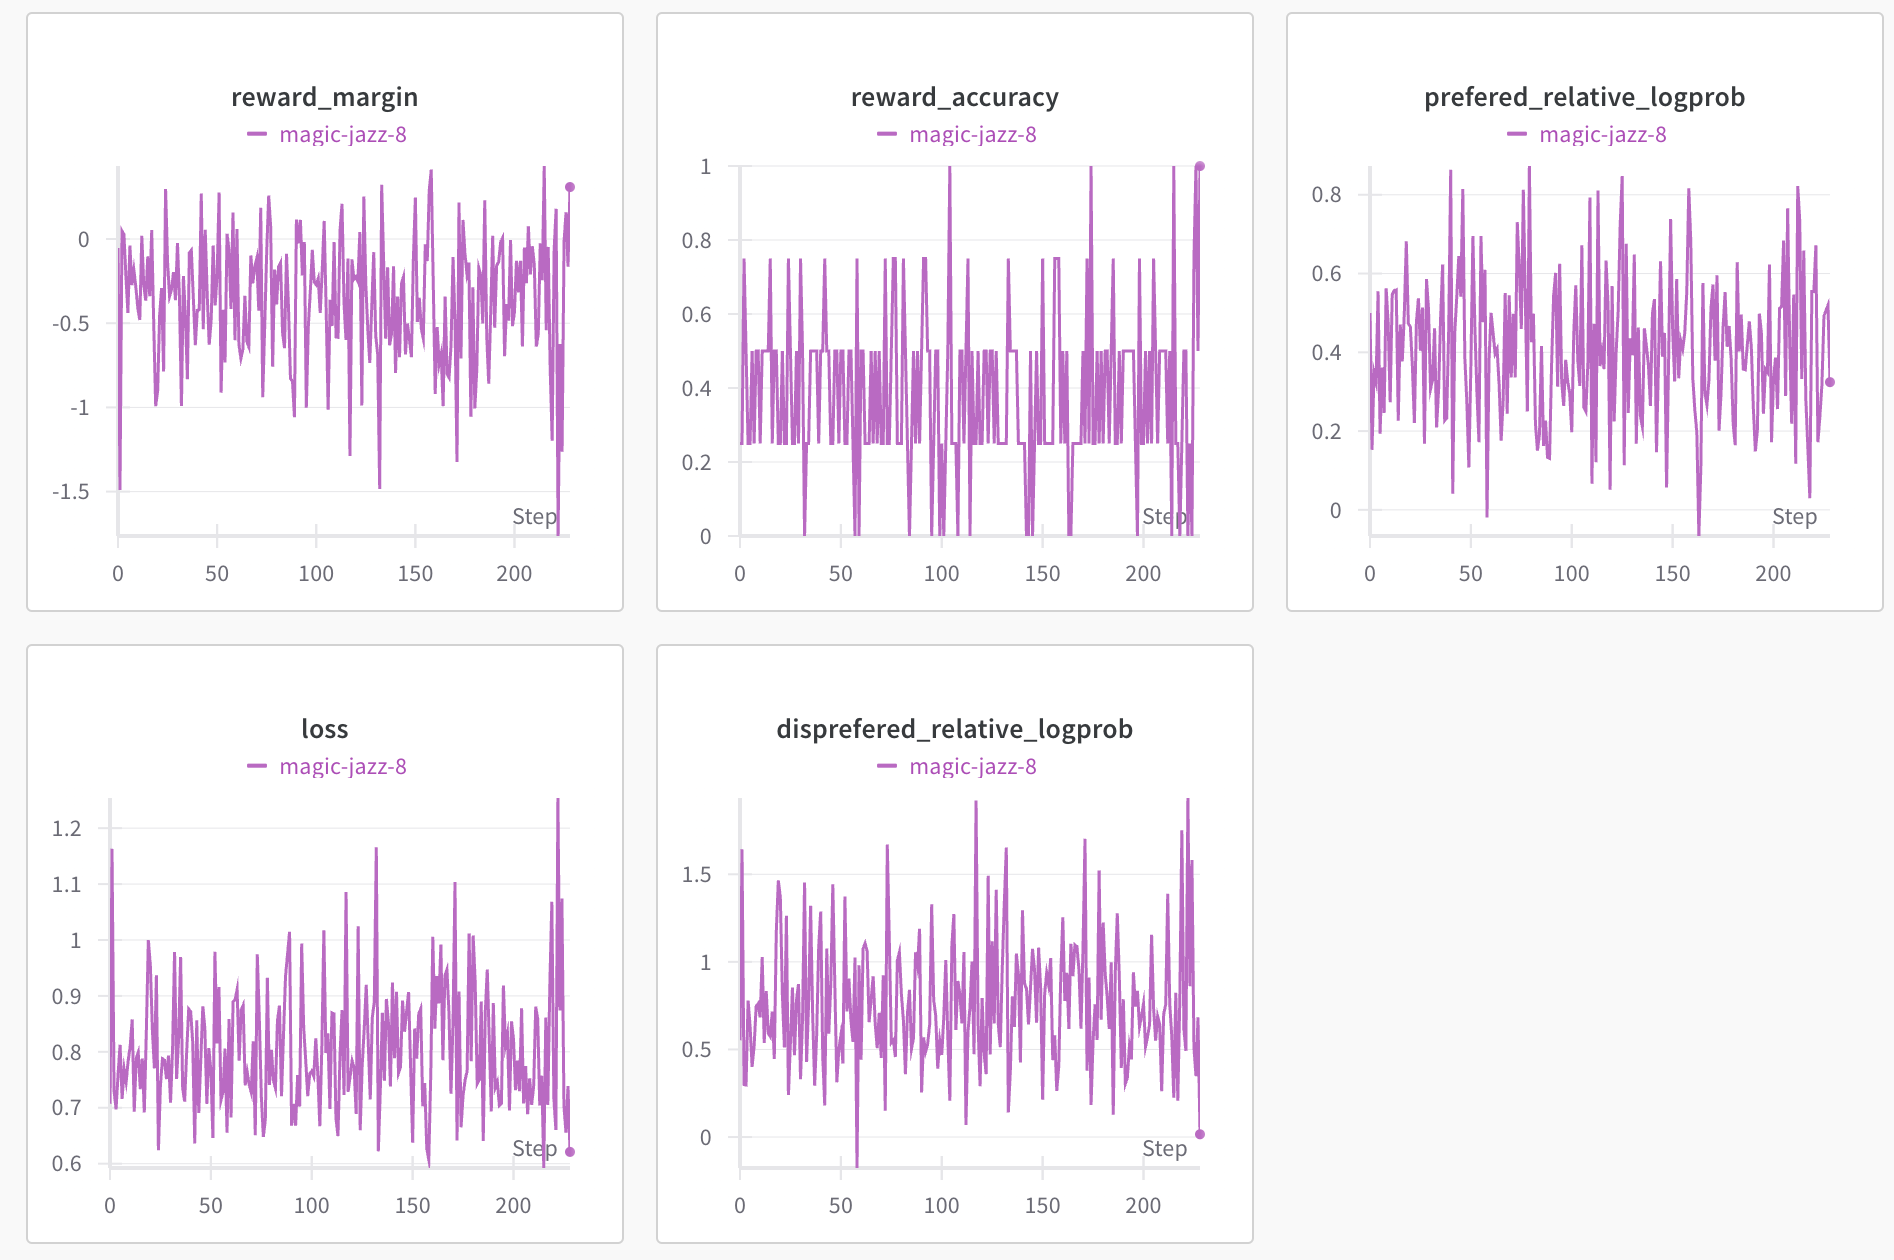

# DPO vs PPO

In [10]:
! pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 20.4 MB/s eta 0:00:00


In [11]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, BitsAndBytesConfig, AdamW
# from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
import random

In [12]:
# set random seed
def seed_everything(seed=2003):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [13]:
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Load model in 8-bit
)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
# dataset and dataloader
dataset_name = "jondurbin/truthy-dpo-v0.1"
dataset = load_dataset(dataset_name, split="train")
print(len(dataset))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)


1016


In [16]:
# load the model to be finetune
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config)
# model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
# load bert model for reward function
bert_model_name = "microsoft/phi-2"
bert_model = AutoModel.from_pretrained(bert_model_name, quantization_config=quantization_config)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name, padding_side='left')
bert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
bert_tokenizer.pad_token = bert_tokenizer.eos_token
# bert_model = AutoModel.from_pretrained(bert_model_name).to(device)

# freeze the bert model
for x in bert_model.parameters():
    x.requires_grad=False

# define the reward function to simulate human factor
def reward_function(texts, postives, negatives):

    # map texts, chosen, rejected to vector
    if isinstance(texts[0],str):
        encoded_texts = bert_tokenizer.batch_encode_plus(
            texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512,
        ).to(device)
        texts_embed = bert_model(input_ids=encoded_texts["input_ids"]).last_hidden_state[:,0]
    else:
        texts_embed = texts

    encoded_postives = bert_tokenizer.batch_encode_plus(
        postives,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512,
    ).to(device)
    postives_embed = bert_model(input_ids=encoded_postives["input_ids"]).last_hidden_state[:,0]

    encoded_negatives = bert_tokenizer.batch_encode_plus(
        negatives,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512,
    ).to(device)
    negatives_embed = bert_model(input_ids=encoded_negatives["input_ids"]).last_hidden_state[:,0]


    # calculate the distance between text/chosen and text/rejected
    pos_distance = F.mse_loss(texts_embed, postives_embed)
    neg_distance = F.mse_loss(texts_embed, negatives_embed)

    # reward score
    margin = 1.0
    rewards = -((pos_distance - neg_distance + margin)*pos_distance**0.5)
    return rewards

texts = ["nice", "cool"]
poss = ["good", "cold"]
negs = ["asdasd", "asdasda"]
res = reward_function(texts, poss, negs)
print(res)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tensor(-0.5811, device='cuda:0', dtype=torch.float16)


In [18]:
# apply lora to accelerate finetuning
lora_config = LoraConfig(
    r=8,  # Low-rank adaptation
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # LoRA applies to attention layers
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)

In [19]:
# optimizer
lr = 1e-4
optimizer = AdamW(model.parameters(), lr=lr)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# training loop

epoches = 10

# collect loss for each iter
collect = []
for epoch in range(epoches):
    losses = []
    cur = 0
    total = len(dataset)
    for batch in dataloader:
        optimizer.zero_grad()

        # build inputs, chosen, rejected
        prompts = ['Instruct: ' + item + '\n' for item in batch['prompt']]
        chosen_responses = ['Output: ' + item for item in batch['chosen']]
        rejected_responses = ['Output: ' + item for item in batch['rejected']]

        # get the embedding of input
        encoded = tokenizer.batch_encode_plus(
            prompts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)
        attention_mask = encoded["attention_mask"]
        encoded_prompts = encoded["input_ids"]
        response_tensors = model(input_ids=encoded_prompts, attention_mask=attention_mask, output_hidden_states=True)

        # calculate reward value
        rewards = reward_function(response_tensors.hidden_states[-1][:,0], chosen_responses, rejected_responses)

        # update weight
        loss = -rewards
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f"{cur}-{cur+len(prompts)}/{total}")
        cur+=len(prompts)
        # break
    all_loss = sum(losses)/len(losses)
    print(f"epoch {epoch+1}/{epoches}: {all_loss}")
    collect.append(all_loss)
    break

0-32/1016
32-64/1016
64-96/1016
96-128/1016
128-160/1016
160-192/1016
192-224/1016
224-256/1016
256-288/1016
288-320/1016
320-352/1016
352-384/1016
384-416/1016
416-448/1016
448-480/1016
480-512/1016
512-544/1016
544-576/1016
576-608/1016
608-640/1016
640-672/1016
672-704/1016
704-736/1016
736-768/1016
768-800/1016
800-832/1016
832-864/1016
864-896/1016
896-928/1016
928-960/1016
960-992/1016
992-1016/1016
epoch 1/10: 0.437255859375


In [21]:
# generate test case

with torch.no_grad():
    for batch in dataloader:

        # build inputs
        prompts = ["Instruct: " + p + "\n" for p in batch['prompt']]

        # get the output tokens
        encoded = tokenizer.batch_encode_plus(
              prompts,
              return_tensors="pt",
              truncation=True,
              padding=True,
              max_length=512,
          ).to(device)
        attention_mask = encoded["attention_mask"]
        encoded_prompts = encoded["input_ids"]
        response_tensors = model.generate(input_ids=encoded_prompts, attention_mask=attention_mask)

        # get the text output
        texts = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

        break

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(texts[3])

In [ ]:
# save the ckpt
model.save_pretrained("ppo.pt")
tokenizer.save_pretrained("ppo_token.pt")

In [ ]:
from peft import PeftModel
model = AutoModelForCausalLM.from_pretrained('ppo.pt', quantization_config=quantization_config)
model = PeftModel.from_pretrained(model, 'ppo.pt')
# model = AutoModelForCausalLM.from_pretrained("ppo.pt", quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained("ppo_token.pt", padding_side='left')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
with torch.no_grad():
    for batch in dataloader:
        prompts = ["Instruct: " + p + "\n" for p in batch['prompt']]

        encoded = tokenizer.batch_encode_plus(
              prompts,
              return_tensors="pt",
              truncation=True,
              padding=True,
              max_length=512,
          ).to(device)
        attention_mask = encoded["attention_mask"]
        encoded_prompts = encoded["input_ids"]

        response_tensors = model.generate(input_ids=encoded_prompts, attention_mask=attention_mask)

        texts = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

        # print(prompts[0])
        print(texts[1])


        break

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token